In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Step 1: Load dataset
df = pd.read_csv('credit_risk_dataset.csv')  # replace with your actual file path

In [2]:
print(df.columns.tolist())

['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']


In [3]:

# Step 2: Handle missing data (if any)
df.fillna(df.median(numeric_only=True), inplace=True)

In [4]:
# Step 3: Feature engineering — select relevant features
# we already have: person_income, loan_percent_income, cb_person_cred_hist_length
# We'll encode categorical features
df_encoded = pd.get_dummies(df, drop_first=True)

In [5]:
# Step 4: Define features and target
X = df_encoded.drop('loan_status', axis=1)
y = df_encoded['loan_status']

In [6]:
# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [7]:
# Step 6: Balance the dataset using SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [8]:

# Step 7: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Step 8: Train all 3 models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train_res)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"\n--- {name} ---")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print(f"AUC Score: {roc_auc:.4f}")

    results[name] = (roc_auc, fpr := roc_curve(y_test, y_proba)[0], tpr := roc_curve(y_test, y_proba)[1])



--- Random Forest ---
Confusion Matrix:
 [[4953  142]
 [ 377 1045]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      5095
           1       0.88      0.73      0.80      1422

    accuracy                           0.92      6517
   macro avg       0.90      0.85      0.88      6517
weighted avg       0.92      0.92      0.92      6517

AUC Score: 0.9273

--- Gradient Boosting ---
Confusion Matrix:
 [[4850  245]
 [ 385 1037]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      5095
           1       0.81      0.73      0.77      1422

    accuracy                           0.90      6517
   macro avg       0.87      0.84      0.85      6517
weighted avg       0.90      0.90      0.90      6517

AUC Score: 0.9124


c:\Users\Cyber World\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:18:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- XGBoost ---
Confusion Matrix:
 [[5032   63]
 [ 373 1049]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96      5095
           1       0.94      0.74      0.83      1422

    accuracy                           0.93      6517
   macro avg       0.94      0.86      0.89      6517
weighted avg       0.93      0.93      0.93      6517

AUC Score: 0.9489


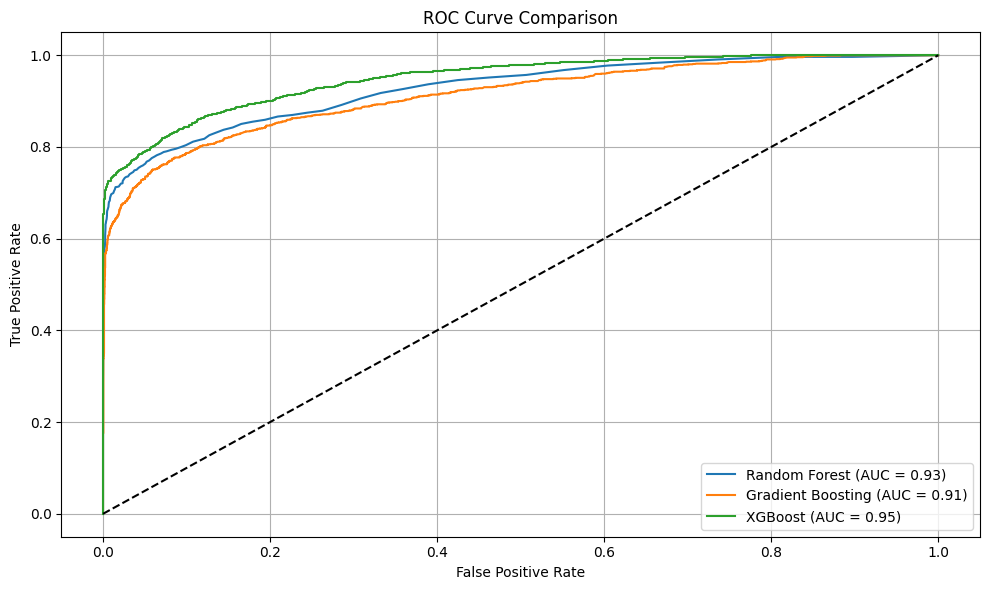

In [10]:
# Step 9: Plot ROC curves
plt.figure(figsize=(10, 6))
for name, (roc_auc, fpr, tpr) in results.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()